In [1]:
# imports
import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
#####################
# my files
# target model
from net_ import target_net
#from net_conv import target_net
# gan architectures
import gans_archs
# advgan training class
from GAN_ import advGAN

if torch.cuda.is_available():  
    dev = 'cuda:0'
else:  
    dev = 'cpu'

print('device: ', dev)

# functions
def transform_data(data_loader_obj):
    ims = []
    lls = []
    for imgs,lbls in data_loader_obj:
        for img,lbl in zip(imgs,lbls):
            ims.append(img)
            lls.append(lbl)
    ims = torch.stack(ims)
    lls = torch.stack(lls)
    return ims,lls

def show_tensor_images(image_tensor, num_images=25):
    image_tensor = image_tensor.reshape(image_tensor.shape[0],1,28,28).cpu().detach()
    size = (1,28,28)
    image_unflat = image_tensor.detach().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

device:  cuda:0


In [7]:
# obtain mnist data and process
batch_size = 128
num_of_classes = 10

def get_indices(dataset,ind_array):
    indices =  []
    for i in range(len(dataset.targets)):
        for ind in ind_array:
            if dataset.targets[i] == ind:
                indices.append(i)
    return indices

dataset = MNIST('.', train=True, download=False,transform=transforms.ToTensor())

idx = get_indices(dataset, np.arange(num_of_classes))
data_loader_rftarget = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
data_loader_target = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
data_loader_gan = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))

classes = np.arange(num_of_classes)

In [9]:
# target model
n_estimators = 100
ims_train,lls_train = transform_data(data_loader_rftarget)
rf = RandomForestClassifier(n_estimators=n_estimators)
rf.fit(ims_train.reshape(len(ims_train),28*28).detach().numpy(),lls_train)
# save the model
PATH = './target_models/rf_model'+str(num_of_classes)+'classes'+'_nest'+str(n_estimators)+'.joblib'
dump(rf, PATH) 
# load the model
rf = load(PATH)

# test random forest accuracy
ims_test,lls_test = transform_data(data_loader_gan)
print('accuracy: ', accuracy_score(rf.predict(ims_test.reshape(len(ims_test),28*28).detach().numpy()),lls_test))

accuracy:  1.0


In [10]:
# train distilled neural network on output from random forest
net = target_net(num_of_classes).to(dev)
criterion_tar = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

path_disttar = './target_models/ff_net_distilled_100est_'+str(num_of_classes)+'classes_device-'+dev+'.pth'
# train and and save the model
net.train(data_loader_target, criterion_tar, optimizer, dev, master_model=rf.predict)
torch.save(net.state_dict(), path_disttar)
# load the model
net = target_net(num_of_classes).to(dev)
net.load_state_dict(torch.load(path_disttar))

print('model accuracy: ', net.accuracy(data_loader_gan,dev))

epoch/epochs: 1/25
epoch/epochs: 2/25
epoch/epochs: 3/25
epoch/epochs: 4/25
epoch/epochs: 5/25
epoch/epochs: 6/25
epoch/epochs: 7/25
epoch/epochs: 8/25
epoch/epochs: 9/25
epoch/epochs: 10/25
epoch/epochs: 11/25
epoch/epochs: 12/25
epoch/epochs: 13/25
epoch/epochs: 14/25
epoch/epochs: 15/25
epoch/epochs: 16/25
epoch/epochs: 17/25
epoch/epochs: 18/25
epoch/epochs: 19/25
epoch/epochs: 20/25
epoch/epochs: 21/25
epoch/epochs: 22/25
epoch/epochs: 23/25
epoch/epochs: 24/25
epoch/epochs: 25/25
model accuracy:  98.72166666666666


In [11]:
# import gen/disc
gen = gans_archs.Generator1()
disc = gans_archs.Discriminator1()

# arguments for GAN training 
tar_criterion=nn.CrossEntropyLoss()
criterion=nn.BCEWithLogitsLoss()
n_epochs=200
batch_size=128
lr=0.00001
device=dev
display_step=500
gen_arch='cov'
###############################
gen_arch_num=1
disc_coeff=2150.
hinge_coeff=150.
adv_coeff=700.
c=0.2
gen_path_extra='distilledrf_genarch_100est_'+str(gen_arch_num)
shape=(1,28,28)
num_of_classes=num_of_classes
################################

# things to investigate
'''
add noise vector in generator
change to 0-1 loss ? 
'''

# initiate advgan
advgan = advGAN(net,gen,disc,tar_criterion=tar_criterion,
                criterion=criterion,n_epochs=n_epochs,
                batch_size=batch_size,num_of_classes=num_of_classes,
                lr=lr,disc_coeff=disc_coeff,hinge_coeff=hinge_coeff,
                adv_coeff=adv_coeff,c=c,gen_path_extra=gen_path_extra,
                device=device,display_step=display_step,shape=shape,gen_arch=gen_arch)

path:  ./advgan_models/distilledrf_genarch_100est_1_device_cuda:0_10classes_2150p0disc_150p0hinge_0p2c_700p0adv.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  1
Step 500: Generator loss: 3004.5758974609394, discriminator loss: 712.9154155578606
% wrong: 0.5 | target model % correct: 0.9921875 | avg. frobenius norm: 6.466989517211914


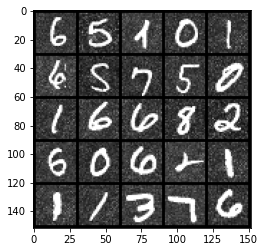

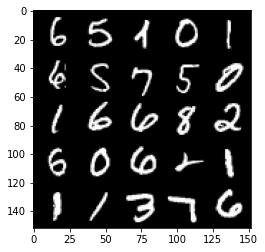

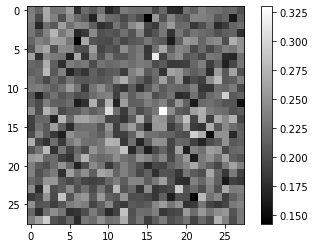

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  2
Step 1000: Generator loss: 2031.2257744140627, discriminator loss: 78.63932826232916
% wrong: 0.6875 | target model % correct: 1.0 | avg. frobenius norm: 3.7081379890441895


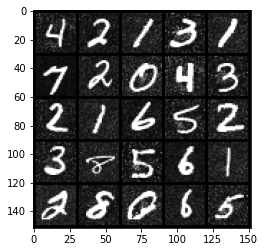

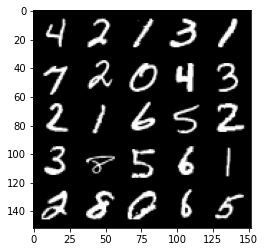

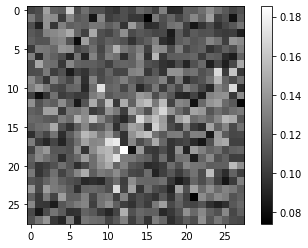

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  3
Step 1500: Generator loss: 1736.5922441406258, discriminator loss: 42.90573141860961
% wrong: 0.7890625 | target model % correct: 0.9921875 | avg. frobenius norm: 2.8280467987060547


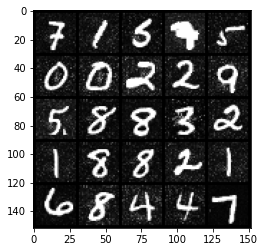

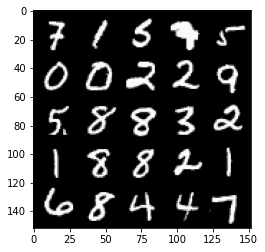

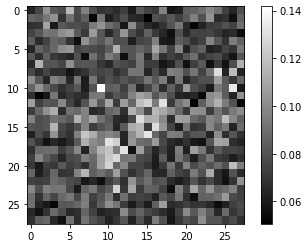

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  4
Step 2000: Generator loss: 1630.3478378906252, discriminator loss: 44.68432875823973
% wrong: 0.7890625 | target model % correct: 0.9765625 | avg. frobenius norm: 2.4550068378448486


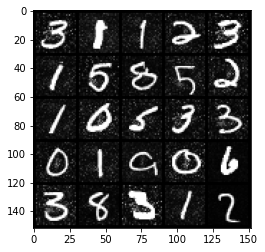

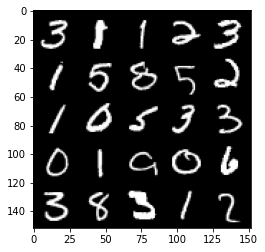

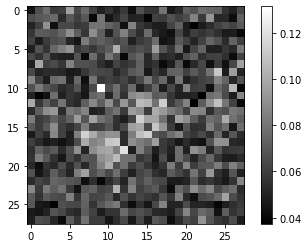

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  5
Step 2500: Generator loss: 1579.7698776855477, discriminator loss: 53.58608890914921
% wrong: 0.71875 | target model % correct: 1.0 | avg. frobenius norm: 2.2265830039978027


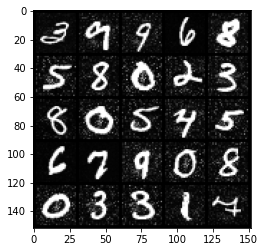

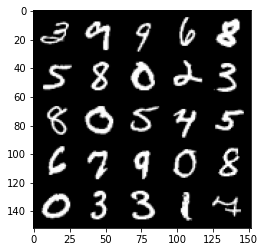

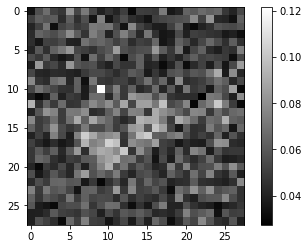

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  6
Step 3000: Generator loss: 1549.2848435058581, discriminator loss: 64.98490158081053
% wrong: 0.7890625 | target model % correct: 1.0 | avg. frobenius norm: 2.1178698539733887


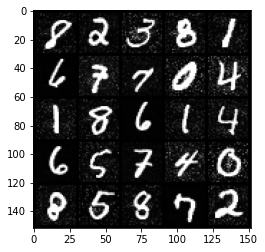

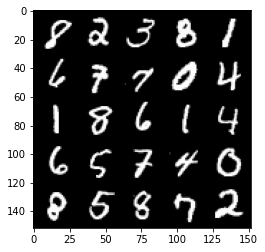

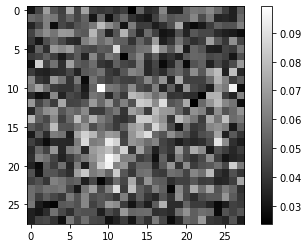

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  7
Step 3500: Generator loss: 1529.2106743164045, discriminator loss: 71.68430030822753
% wrong: 0.7578125 | target model % correct: 0.984375 | avg. frobenius norm: 1.985449194908142


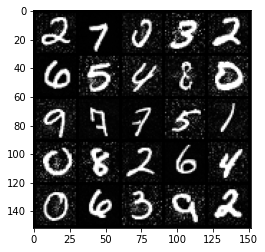

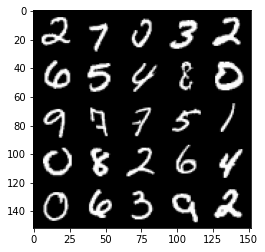

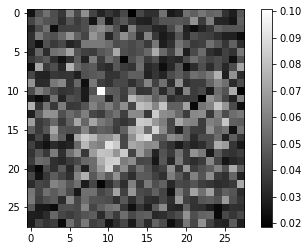

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  8
Step 4000: Generator loss: 1516.905768798828, discriminator loss: 75.18321487426755
% wrong: 0.6796875 | target model % correct: 0.9765625 | avg. frobenius norm: 1.7681465148925781


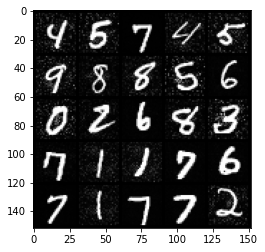

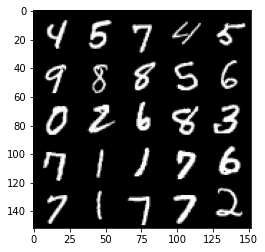

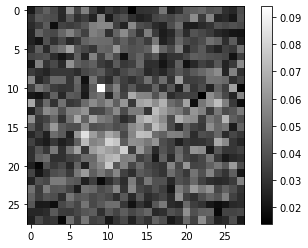

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  9
Step 4500: Generator loss: 1506.5966235351543, discriminator loss: 77.60499996185303
% wrong: 0.828125 | target model % correct: 0.9921875 | avg. frobenius norm: 1.9413502216339111


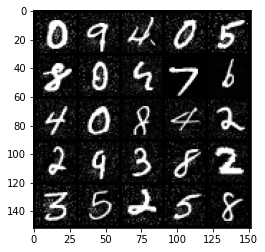

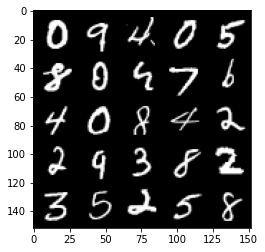

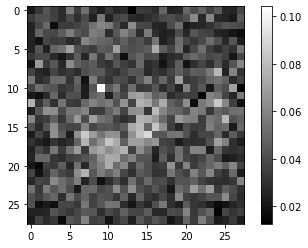

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  10
Step 5000: Generator loss: 1498.8421325683603, discriminator loss: 77.44189348602293
% wrong: 0.78125 | target model % correct: 0.9765625 | avg. frobenius norm: 1.845583200454712


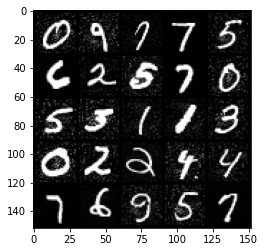

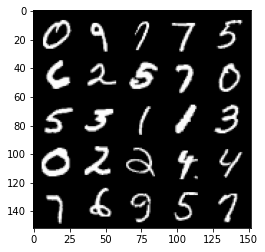

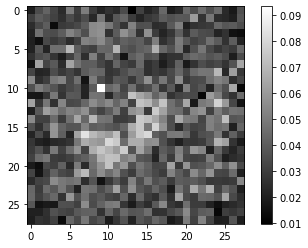

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  11
Step 5500: Generator loss: 1496.2464755859369, discriminator loss: 83.02155180358898
% wrong: 0.7578125 | target model % correct: 0.9765625 | avg. frobenius norm: 1.7292388677597046


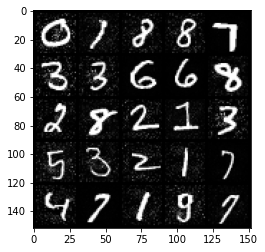

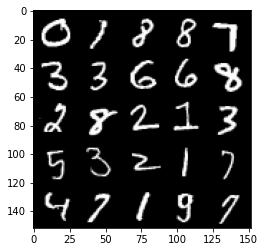

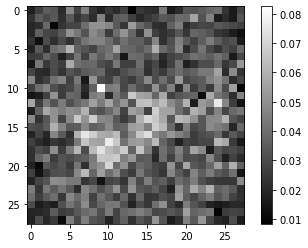

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  12
Step 6000: Generator loss: 1490.232313476562, discriminator loss: 87.39131092071524
% wrong: 0.8046875 | target model % correct: 0.9921875 | avg. frobenius norm: 1.8632731437683105


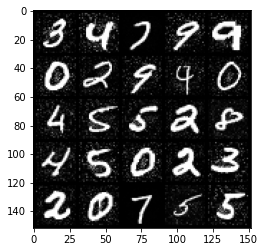

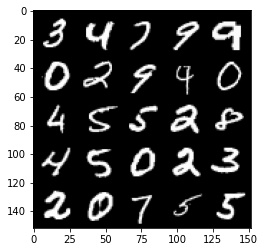

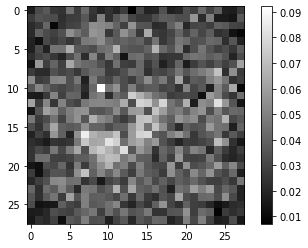

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  13
Step 6500: Generator loss: 1487.0794118652345, discriminator loss: 94.47193364715574
% wrong: 0.8203125 | target model % correct: 0.984375 | avg. frobenius norm: 1.8617479801177979


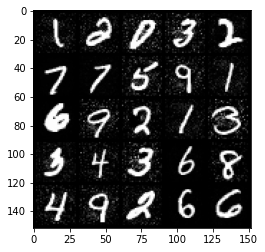

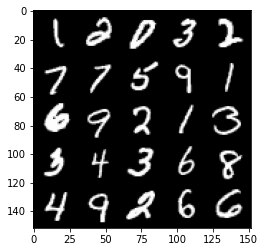

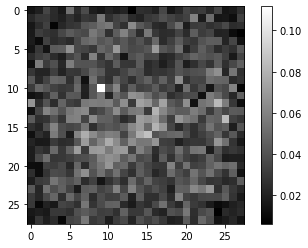

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  14
Step 7000: Generator loss: 1483.4473464355467, discriminator loss: 104.40927407073981
% wrong: 0.7890625 | target model % correct: 0.9921875 | avg. frobenius norm: 1.797741174697876


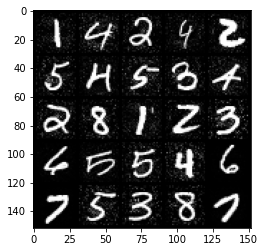

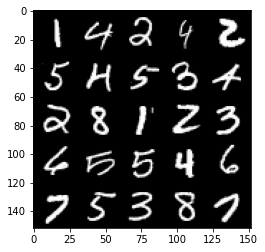

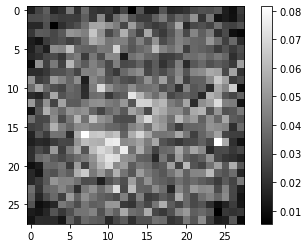

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  15
Step 7500: Generator loss: 1481.0125864257814, discriminator loss: 113.05099016571045
% wrong: 0.78125 | target model % correct: 0.9921875 | avg. frobenius norm: 1.6697458028793335


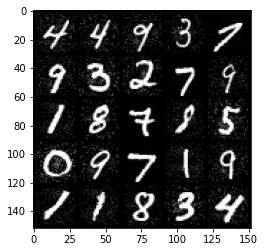

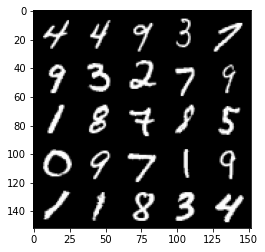

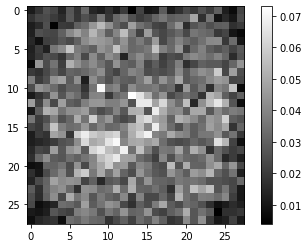

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  17
Step 8000: Generator loss: 1478.40966430664, discriminator loss: 124.9075431365967
% wrong: 0.8046875 | target model % correct: 0.984375 | avg. frobenius norm: 1.7891969680786133


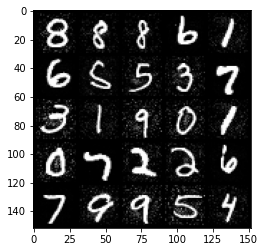

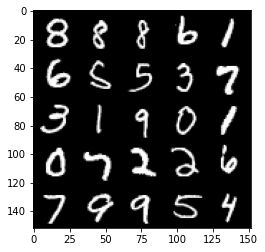

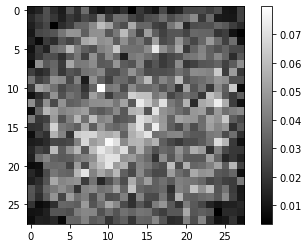

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  18
Step 8500: Generator loss: 1476.7531713867188, discriminator loss: 135.31893553161626
% wrong: 0.75 | target model % correct: 0.9921875 | avg. frobenius norm: 1.673730731010437


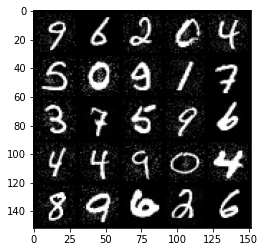

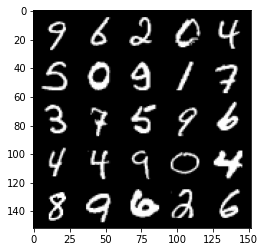

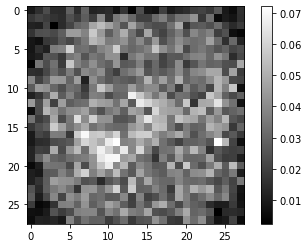

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:  19
Step 9000: Generator loss: 1475.557025146484, discriminator loss: 146.08852827453597
% wrong: 0.7421875 | target model % correct: 0.984375 | avg. frobenius norm: 1.7107903957366943


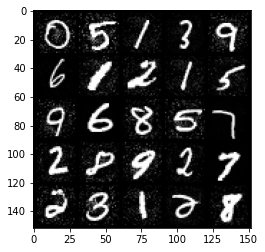

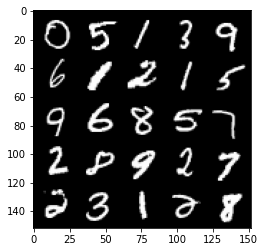

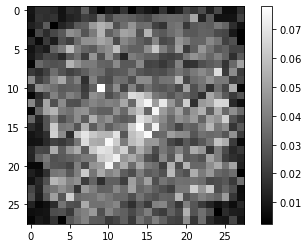

In [ ]:
%%time 
# train the gan
gen,disc = advgan.train(data_loader_gan)

In [ ]:
# load the generator 
path = advgan.gen_path
full_path = path[0:15] + '/models_keep' + path[15::]
gen = advgan.load_gen(full_path)

In [ ]:
# test transferability from adv examples for the nn to the rf
counter = 0.
total_rf_clean = 0.
total_nn_clean = 0.
total_rf_adv = 0.
total_nn_adv = 0.
for data,label in DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx)):
    rf_output_clean = rf.predict(data.reshape(len(data),28*28).cpu().detach().numpy())
    nn_output_clean = torch.argmax(net(data.reshape(len(data),28*28).to(dev)),dim=1)
    # make adv example
    pert = gen(data.reshape(len(data),28*28).to(dev))
    adv_img = (data.reshape(len(data),28*28).to(dev) + pert).to(dev)
    rf_output_adv = rf.predict(adv_img.cpu().detach().numpy())
    nn_output_adv = torch.argmax(net(adv_img.to(dev)),dim=1)
    # calculate and return accuracy 
    total_rf_clean += accuracy_score(rf_output_clean,label.cpu().detach().numpy())
    total_nn_clean += accuracy_score(nn_output_clean.cpu().detach().numpy(),label.cpu().detach().numpy())
    total_rf_adv += accuracy_score(rf_output_adv,label.cpu().detach().numpy())
    total_nn_adv += accuracy_score(nn_output_adv.cpu().detach().numpy(),label.cpu().detach().numpy())
    counter += 1.
print('rf accuracy (clean): ', total_rf_clean/counter)
print('nn accuracy (clean): ', total_nn_clean/counter)
print('% adv rf: ', 1.-total_rf_adv/counter)
print('% adv nn: ', 1.-total_nn_adv/counter)

show_tensor_images(adv_img)

In [ ]:
# load a net w/o the train method (messes up art if it is there)
from net_ import target_net
del target_net.train
net_art = target_net(num_of_classes)
net_art.load_state_dict(torch.load(path_disttar))

# data to attack
ims_attack,actual_lables = transform_data(data_loader_test)
ims_attack = ims_attack.reshape(ims_attack.shape[0],28*28)

In [ ]:
##### FGM

# ART torch classifier model
from art.estimators.classification import PyTorchClassifier
classifier = PyTorchClassifier(
    model=net_art,
    clip_values=(0, 1),
    loss=criterion_tar,
    optimizer=optimizer,
    input_shape=(28*28,),
    nb_classes=num_of_classes)

# transferability of FGM attack
from art.attacks.evasion import FastGradientMethod
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_fgm_adv = attack.generate(x=ims_attack)

# model output
rf_output_clean = rf.predict(ims_attack)
nn_output_clean = torch.argmax(net_art(ims_attack.to(dev)),dim=1)
rf_output_adv = rf.predict(x_fgm_adv)
nn_output_adv = torch.argmax(net_art(torch.from_numpy(x_fgm_adv).to(dev)),dim=1)
    
# calculate and return accuracy 
acc_rf_clean = accuracy_score(rf_output_clean,actual_lables)
acc_nn_clean = accuracy_score(nn_output_clean.cpu().detach().numpy(),actual_lables)
acc_rf_adv = accuracy_score(rf_output_adv,actual_lables)
acc_nn_adv = accuracy_score(nn_output_adv.cpu().detach().numpy(),actual_lables)

print('rf accuracy (clean): ', acc_rf_clean)
print('nn accuracy (clean): ', acc_nn_clean)
print('% adv rf: ', 1.-acc_rf_adv)
print('% adv nn: ', 1.-acc_nn_adv)
show_tensor_images(torch.from_numpy(x_fgm_adv))

In [ ]:
##### CW

# ART torch classifier model
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import CarliniL2Method,CarliniLInfMethod

classifier = PyTorchClassifier(
    model=net_art,
    clip_values=(0, 1),
    loss=criterion_tar,
    optimizer=optimizer,
    input_shape=(28*28,),
    nb_classes=num_of_classes)

# this attack takes a long time, so for initial experiments, lets just use a subset of the data
k = 100
# transferability of CW attack
attack = CarliniL2Method(classifier)
CW_adv_img = attack.generate(x=ims_attack[0:k],y=((actual_lables+1)%2)[0:k])
np.save('./target_models/CW_adv_img.npy',CW_adv_img)
#CW_adv_img = np.load('./target_models/CW_adv_img.npy')

# model output
rf_output_clean = rf.predict(ims_attack[0:k])
nn_output_clean = torch.argmax(net_art(ims_attack.to(dev)[0:k]),dim=1)
rf_output_adv = rf.predict(CW_adv_img)
nn_output_adv = torch.argmax(net_art(torch.from_numpy(CW_adv_img).to(dev)),dim=1)
    
# calculate and return accuracy 
acc_rf_clean = accuracy_score(rf_output_clean,actual_lables[0:k])
acc_nn_clean = accuracy_score(nn_output_clean.cpu().detach().numpy(),actual_lables[0:k])
acc_rf_adv = accuracy_score(rf_output_adv,actual_lables[0:k])
acc_nn_adv = accuracy_score(nn_output_adv.cpu().detach().numpy(),actual_lables[0:k])

print('rf accuracy (clean): ', acc_rf_clean)
print('nn accuracy (clean): ', acc_nn_clean)
print('% adv rf: ', 1.-acc_rf_adv)
print('% adv nn: ', 1.-acc_nn_adv)
show_tensor_images(torch.from_numpy(CW_adv_img))

In [ ]:
# comparing to noisy data 
imgs_noisey = ims_attack + 0.25*torch.rand(ims_attack.shape)

# model output
rf_output_clean = rf.predict(ims_attack)
nn_output_clean = torch.argmax(net_art(ims_attack.to(dev)),dim=1)
rf_output_adv = rf.predict(imgs_noisey.detach().cpu().numpy())
nn_output_adv = torch.argmax(net_art(imgs_noisey.to(dev)),dim=1)
    
# calculate and return accuracy 
acc_rf_clean = accuracy_score(rf_output_clean,actual_lables)
acc_nn_clean = accuracy_score(nn_output_clean.cpu().detach().numpy(),actual_lables)
acc_rf_adv = accuracy_score(rf_output_adv,actual_lables)
acc_nn_adv = accuracy_score(nn_output_adv.cpu().detach().numpy(),actual_lables)

print('rf accuracy (clean): ', acc_rf_clean)
print('nn accuracy (clean): ', acc_nn_clean)
print('% adv rf: ', 1.-acc_rf_adv)
print('% adv nn: ', 1.-acc_nn_adv)
show_tensor_images(torch.from_numpy(imgs_noisey))